## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.


<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [87]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, we will read in the `ab_data.csv` data, and store it in `df`. 

a. Read in the dataset and take a look at the top few rows here:

In [88]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Number of rows in the dataset:

In [89]:
df.shape[0]

294478

c. The number of unique users in the dataset:

In [90]:
df['user_id'].nunique()

290584

d. The proportion of users converted:

In [91]:
len(df.query('converted == 1').groupby('user_id'))/290584

0.12104245244060237

e. The number of times the `new_page` and `treatment` don't match:

In [92]:
df.query('group == "treatment" & landing_page == "old_page"').count() + \
df.query('group == "control" & landing_page == "new_page"').count()

user_id         3893
timestamp       3893
group           3893
landing_page    3893
converted       3893
dtype: int64

f. Checking for missing values:

In [93]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page. 

a. We will create a new dataset that excludes these rows and store the new dataframe in **df2**.

In [94]:
dlt = df.query('group == "treatment" & landing_page == "old_page"').index.values

In [95]:
dlt = np.append(dlt, df.query('group == "control" & landing_page == "new_page"').index.values)

In [96]:
df2 = df.drop(dlt, 0)

In [97]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.`

a. Unique **user_id**s in **df2**:

In [98]:
df2['user_id'].nunique()

290584

b. Duplicated **user_ids**:

In [99]:
df2[df2['user_id'].duplicated() == True].user_id

2893    773192
Name: user_id, dtype: int64

c. The row information for the duplicated **user_id**:

In [100]:
df2[df2['user_id'].duplicated() == True]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. We will remove **one** of the rows with a duplicate **user_id**:

In [101]:
df2.drop(2893, 0, inplace=True)
#2893 is the index we got from the info above

`4.`

a. The probability of an individual converting regardless of the page they receive:

In [102]:
df2.query('converted == 1').shape[0]/290584

0.11959708724499628

b. The probability that an individual converted given that they were in the `control` group:

In [103]:
# first we get the number of total individuals in the control group
nOcontrol = df2.query('group == "control"').shape[0]

In [104]:
# we divide the number of those converted from the group over the total
df2.query('converted == 1 & group == "control"').shape[0]/nOcontrol

0.1203863045004612

c. The probability that an individual converted Given that they were in the `treatment` group:

In [105]:
# we get the total of the individuals in the treatment group
nOtreatment = df2.query('group == "treatment"').shape[0]

In [106]:
# we divide the number of those converted from the group over the total
df2.query('converted == 1 & group == "treatment"').shape[0]/nOtreatment

0.11880806551510564

d. The probability that an individual received the new page:

In [107]:
df2.query('landing_page == "new_page"').shape[0]/df2.shape[0]

0.5000619442226688

**e. There is no sufficient evidence to conclude that the new treatment page leads to more conversions. The probability of an individual in the treatment group converting is 5.9% wherein it's 6% for individuals in the control group. The difference between the two is too small to make such conclusions**

<a id='ab_test'></a>
### Part II - A/B Test


`1.` Assuming that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%:

**$H_{0}$** = **$p_{new}$** - **$p_{old}$** <= 0

**$H_{1}$** = **$p_{new}$** - **$p_{old}$** > 0

**$p_{old}$** and **$p_{new}$**: the converted rates for the old and new pages.

`2.` Assuming under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assuming they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

First, we will use a sample size for each page equal to the ones in **ab_data.csv:** <br><br>

a. The **conversion rate** for $p_{new}$ under the null:

In [108]:
pnew = df2['converted'].mean()
pnew

0.11959708724499628

b. The **conversion rate** for $p_{old}$ under the null: 

In [109]:
pold = df2['converted'].mean()
pold

0.11959708724499628

c. $n_{new}$, the number of individuals in the treatment group:

In [110]:
nnew = df2.query('group == "treatment"').shape[0]
nnew

145310

d. $n_{old}$, the number of individuals in the control group:

In [111]:
nold = len(df2.query('group == "control"'))
nold

145274

e. We will simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null, and store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [112]:
new_page_converted = np.random.choice([0, 1], size = nnew, p = [pnew, 1 - pnew])

f. Now we will simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null and store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [113]:
old_page_converted = np.random.choice([0, 1], size = nold, p = [pold, 1 - pold])

g. $p_{new}$ - $p_{old}$ for our simulated values from part (e) and (f):

In [114]:
new_page_converted.mean() - old_page_converted.mean()

0.0032302861824287099

h. Now, we will perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.

In [115]:
# we will create 10,000 pnew - pold values and store them in p_diffs array
p_diffs = []

for i in range(10000):
    new_page_converted = np.random.choice([0, 1], size = nnew, p = [pnew, 1 - pnew])
    old_page_converted = np.random.choice([0, 1], size = nold, p = [pold, 1 - pold])
    p_diffs.append(new_page_converted.mean() - old_page_converted.mean())

i. A histogram of the **p_diffs**:

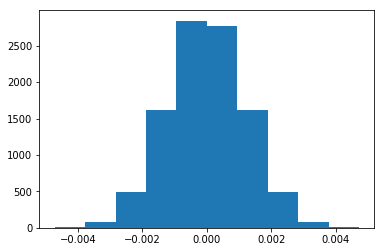

In [116]:
plt.hist(p_diffs);

j. Now we want to find the proportion of the **p_diffs** greater than the actual difference observed in **ab_data.csv**:

First, we will find the actual difference observed in **ab_data.csv**:

In [117]:
treatment = df2.query('group == "treatment"')['converted'].mean()
control = df2.query('group == "control"')['converted'].mean()
act_diffs = treatment - control

Then the proportion of the p_diffs greater than the actual difference in **ab_data.csv:**

In [118]:
p_diffs = np.array(p_diffs)
(p_diffs > act_diffs).mean()

0.90620000000000001

**k. What we just computed is a term referred to as the probability value or pvalue. Pvalue is the probability of obtaining test results at least as extreme as the results actually observed, assuming that the null hypothesis is correct. Having a large pvalue indicates weak evidence against the null hypothesis, so we fail to reject it.**

l. We could also use a built-in to achieve similar results. We will let `n_old` and `n_new` refer to the number of rows associated with the old page and new pages, respectively.

In [119]:
import statsmodels.api as sm

convert_old = df2.query('group == "control"').converted.sum()
convert_new = df2.query('group == "treatment"').converted.sum()
n_old = df2.query('group == "control"').shape[0]
n_new = df2.query('group == "treatment"').shape[0]

m. Now we will use `stats.proportions_ztest` to compute our test statistic and p-value:

In [120]:
zscore, pvalue = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative='smaller')
print(zscore, pvalue)

1.31092419842 0.905058312759


n. Now we want to find What the z-score and p-value we computed mean for the conversion rates of the old and new pages. Do they agree with the findings in parts **j.** and **k.**?

In [121]:
#first we need to compute the significance of our z-score:

from scipy.stats import norm
norm.cdf(zscore)

0.90505831275902449

In [122]:
#second, we compute our critical value at 95% confidence:

norm.ppf(1-(0.05))

1.6448536269514722

**Since 1.31 < 1.64 this disapproves our alternative hypothesis. Concluding that the conversion rate for the new page is not more than the old page. Also, the pvalue computed is almost equal to the one computed in part j and k. Therefore, we agree with our previous findings and fail to reject the null hypothesis.**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, we will see that the result we achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, we will be performing **Logistic Regression**.

b. We will use **statsmodels** to fit the regression model we specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.

In [123]:
# Adding the intercept column
df2['intercept'] = 1

In [124]:
# we need the 1's to refer to treatment, and 0's to control, so we will
# drop the dummy column since it will generate the opposite, and we'll
# use the ab_page:
df2[['dummy','ab_page']] = pd.get_dummies(df2['group'])
df2.drop('dummy', axis=1, inplace=True)
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. We will use **statsmodels** to instantiate our regression model on the two columns we created in part **b.**, then fit the model using them to predict whether or not an individual converts. 

In [125]:
logit = sm.Logit(df2['converted'],df2[['intercept' ,'ab_page']])

d. Now we will provide the summary of our model below:

In [126]:
# A workaround for an error
from scipy import stats
stats.chisqprob = lambda chisq, df2: stats.chi2.sf(chisq, df2)
## 

## Summary of model
result = logit.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Thu, 25 Jun 2020   Pseudo R-squ.:               8.077e-06
Time:                        13:44:14   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

**e. The pvalue computed just now is 0.19 which is way less than the one computed in part II, which was 0.9. The reason for that is because the null and alternative hypotheses in this part are different from the previous ones. The test in Part II was one-sided, whereas this one is two-sided**

**f. It will be good to explore whether other factors have higher influence, since it may also help with defining outliers. However, a disadvantage that may occur is inaccurate results due to correlation errors. Considering all influencing factors is not easy to execute, and focusing on smaller comparisons may yield better results**

g. Now along with testing if the conversion rate changes for different pages, we will also add an effect based on which country a user lives in.


In [127]:
# we will read the data from the countries file then join it with our df2
countries_data = pd.read_csv('./countries.csv')
countries_data.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [128]:
df2 = df2.join(countries_data.set_index('user_id'), on = 'user_id')

h. We would now like to look at an interaction between page and country to see if there are significant effects on conversion.

In [129]:
df2[['UK','US']] = pd.get_dummies(df2['country'])[['UK','US']]

In [130]:
logit = sm.Logit(df2['converted'], df2[['intercept', 'UK', 'US']])

results = logit.fit()

results.summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Thu, 25 Jun 2020   Pseudo R-squ.:               1.521e-05
Time:                        13:44:15   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0375      0.026    -78.364      0.000      -2.088      -1.987
UK             0.0507      0.028      1.786      0.074      -0.005       0.106
US             0.0408      0.027      1.518      0.129      -0.012       0.093
==============================================================================
"""

The statistical evidence does not allow us to conclude that there is an impact since all the pvalues are more than 0.05. So, once again we cannot reject the null hypothesis.

<a id='conclusions'></a>
## Finishing Up

> Congratulations!  You have reached the end of the A/B Test Results project!  You should be very proud of all you have accomplished!


## References:
### https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/
### https://github.com/abodacs/Analyze-AB-Test-Results/blob/master/Analyze_ab_test_results_notebook.ipynb
### https://github.com/khaledimad/Analyze-A-B-Test-Results/blob/master/Analyze_ab_test_results_notebook.ipynb
### https://github.com/statsmodels/statsmodels/issues/3931

In [134]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0